In [338]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

In [339]:
torch.__version__

'2.6.0'

In [340]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [341]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [342]:
x_train = torch.from_numpy(train_dataset['train_set_x'][:])
y_train = torch.from_numpy(train_dataset['train_set_y'][:])

x_test = torch.from_numpy(test_dataset['test_set_x'][:])
y_test = torch.from_numpy(test_dataset['test_set_y'][:])

print(f"x_train shape: {x_train.shape}")
print(f"x_train type: {x_train.dtype}")

x_train shape: torch.Size([1080, 64, 64, 3])
x_train type: torch.uint8


In [343]:
class SignDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [344]:
train_dataset = SignDataset(x_train.view(x_train.size(0), -1) / 255.0, y_train)
test_dataset = SignDataset(x_test.view(x_test.size(0), -1) / 255.0, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [345]:
x_example, y_example = next(iter(train_loader))
print(x_example[0].shape)
print(x_example[0].dtype)

torch.Size([12288])
torch.float32


In [346]:
unique_labels = set()
for element in y_train.numpy():
    unique_labels.add(element)
print(unique_labels)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}


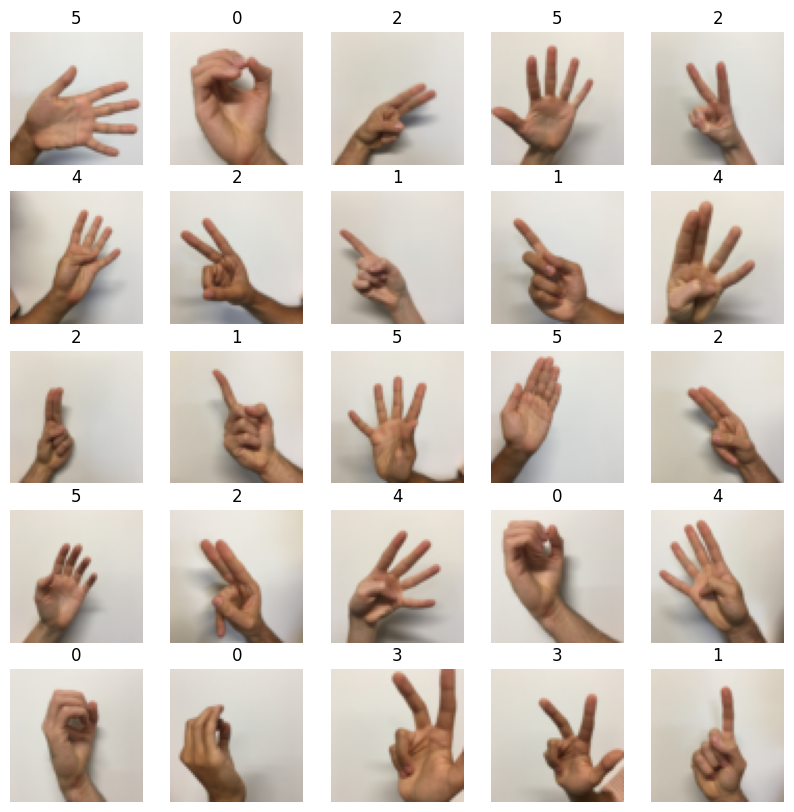

In [347]:
images_iter = iter(x_train)
labels_iter = iter(y_train)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

In [348]:
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        
        # Define the layers
        self.layer1 = nn.Linear(12288, 25)
        self.layer2 = nn.Linear(25, 12)
        self.layer3 = nn.Linear(12, 6)
        
        # Initialize weights using Xavier Normal
        nn.init.xavier_normal_(self.layer1.weight)
        nn.init.xavier_normal_(self.layer2.weight)
        nn.init.xavier_normal_(self.layer3.weight)
        
        # Initialize biases to zero
        nn.init.zeros_(self.layer1.bias)
        nn.init.zeros_(self.layer2.bias)
        nn.init.zeros_(self.layer3.bias)
        
        # Define ReLU activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Flatten the input if it's not already flat
        X = x.view(x.size(0), -1)
        
        # Forward pass through the layers
        A1 = self.relu(self.layer1(X))
        A2 = self.relu(self.layer2(A1))
        Z3 = self.layer3(A2)  # No activation on the last layer for classification
        
        return Z3

In [349]:
class CategoricalAccuracy:
    def __init__(self):
        self.correct = 0
        self.total = 0
        
    def update_state(self, y_pred, y_true):
        y_pred_class = torch.argmax(y_pred, dim=1)
        y_true_class = y_true
        
        self.correct += (y_pred_class == y_true_class).sum().item()
        self.total += len(y_pred_class)
        
    def result(self):
        return self.correct / self.total if self.total > 0 else 0
        
    def reset_state(self):
        self.correct = 0
        self.total = 0

In [350]:
def model(train_loader, test_loader, learning_rate = 0.0001,
          num_epochs = 1500, print_cost = True):
    """
    Implements a three-layer pytorch neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    train_acc = []
    test_acc = []
    
    # Initialize your parameters
    sign_model = SignLanguageModel()

    optimizer = optim.Adam(sign_model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    # Set device
    sign_model.to(device)
    
    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    test_accuracy = CategoricalAccuracy()
    train_accuracy = CategoricalAccuracy()
    
    # We can get the number of elements of a dataset using the cardinality method
    m = len(train_loader)

    # Do the training loop
    for epoch in range(num_epochs):

        sign_model.train()

        epoch_total_loss = 0.
        
        #We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_state()

        for data, target in train_loader:

            # Move data to device
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            
            Z3 = sign_model(data)

            minibatch_total_loss = criterion(Z3, target)

            # Backward pass
            minibatch_total_loss.backward()
        
            # Update weights
            optimizer.step()

            # We accumulate the accuracy of all the batches
            train_accuracy.update_state(Z3, target)
            
            epoch_total_loss += minibatch_total_loss.item()
        
        # We divide the epoch total loss over the number of samples
        epoch_total_loss /= m

        # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_total_loss))
            print("Train accuracy:", train_accuracy.result())
            
            # We evaluate the test set every 10 epochs to avoid computational overhead
            with torch.no_grad():  # Disable gradient computation
                for data, target in test_loader:

                    # Move data to device
                    data, target = data.to(device), target.to(device)

                    # Forward pass
                    Z3 = sign_model(data)
            
                    # Calculate accuracy for this batch
                    test_accuracy.update_state(Z3, target)
            
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_total_loss)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_state()


    return costs, train_acc, test_acc

In [351]:
costs, train_acc, test_acc = model(train_loader=train_loader, test_loader=test_loader, num_epochs=1000)

Cost after epoch 0: 1.807200
Train accuracy: 0.16574074074074074
Test_accuracy: 0.16666666666666666
Cost after epoch 10: 1.682976
Train accuracy: 0.1648148148148148
Test_accuracy: 0.19166666666666668
Cost after epoch 20: 1.581193
Train accuracy: 0.3
Test_accuracy: 0.23333333333333334
Cost after epoch 30: 1.529478
Train accuracy: 0.35185185185185186
Test_accuracy: 0.3416666666666667
Cost after epoch 40: 1.442174
Train accuracy: 0.3972222222222222
Test_accuracy: 0.4
Cost after epoch 50: 1.342137
Train accuracy: 0.41944444444444445
Test_accuracy: 0.36666666666666664
Cost after epoch 60: 1.262437
Train accuracy: 0.44722222222222224
Test_accuracy: 0.3333333333333333
Cost after epoch 70: 1.175251
Train accuracy: 0.48703703703703705
Test_accuracy: 0.43333333333333335
Cost after epoch 80: 1.103338
Train accuracy: 0.5481481481481482
Test_accuracy: 0.4583333333333333
Cost after epoch 90: 1.048443
Train accuracy: 0.5898148148148148
Test_accuracy: 0.5416666666666666
Cost after epoch 100: 0.989836


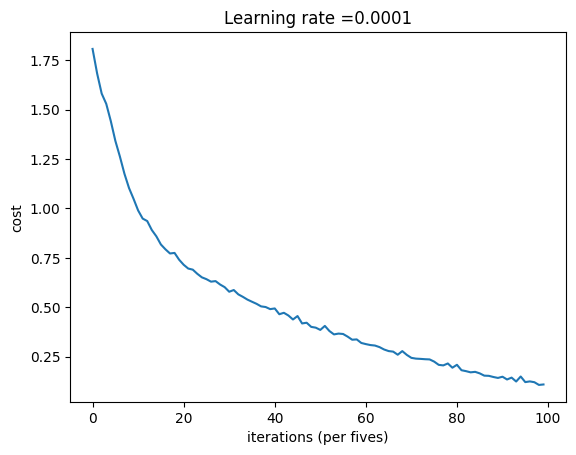

In [352]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


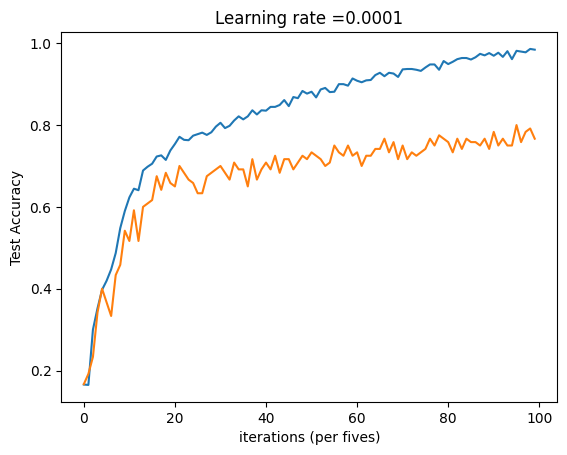

In [353]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()
